In [2]:
! pip show tensorflow
import tensorflow as tf
tf.config.list_physical_devices('GPU')

Name: tensorflow
Version: 2.6.4
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: absl-py, astunparse, clang, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-io, tensorflow-serving-api, tensorflow-transform, tfx-bsl, witwidget


2023-01-12 08:28:50.733040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 08:28:50.849251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 08:28:50.850072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, metrics
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa
from IPython.display import clear_output

# BiLSTM_model

In [4]:
ds_path = '/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/'
image_size = (224, 224)
batch_size = 32
seed = 24

train_ds = image_dataset_from_directory(ds_path+'train',
                                        image_size=image_size,
                                        label_mode='categorical',
                                        color_mode='rgb',
                                        seed=seed)
test_ds = image_dataset_from_directory(ds_path+'test',
                                       image_size=image_size,
                                       label_mode='categorical',
                                       color_mode='rgb',
                                       seed=seed)
val_ds = image_dataset_from_directory(ds_path+'val',
                                      image_size=image_size,
                                      label_mode='categorical',
                                      color_mode='rgb',
                                      seed=seed)

classes = train_ds.class_names
no_of_classes = len(classes)

print(classes)
plt.style.use('seaborn-white')
seed = 24
tf.random.set_seed(seed)

Found 4861 files belonging to 4 classes.
Found 1625 files belonging to 4 classes.
Found 1620 files belonging to 4 classes.
['Corona Virus Disease', 'Normal', 'Pneumonia', 'Tuberculosis']


In [18]:
four_class_model_bilstm = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3),strides=1,padding='same', activation='relu', input_shape = (224,224,3)),
    layers.MaxPool2D((2,2),strides=2,padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3),strides=1,padding='same', activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3),strides=1,padding='same', activation='relu'),
    layers.MaxPool2D((2,2),strides=2,padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3),strides=1,padding='same', activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3),strides=1,padding='same', activation='relu'),
    layers.MaxPool2D((2,2),strides=2,padding='same'),
    layers.BatchNormalization(),    
    
    layers.Conv2D(filters=256, kernel_size=(3, 3),strides=1,padding='same', activation='relu'),
    layers.MaxPool2D((2,2),strides=2,padding='same'),
    layers.BatchNormalization(),    
    
    layers.Conv2D(filters=512, kernel_size=(3, 3),strides=1,padding='same', activation='relu'),
    layers.MaxPool2D((2,2),strides=2,padding='same'),
    layers.BatchNormalization(),    
    
    
    layers.Reshape((-1, 512)),
    layers.Bidirectional(layers.LSTM(512, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(512)),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax'),
], name='four_class_model_bilstm')
four_class_model_bilstm.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       metrics.Precision(), 
                       metrics.Recall(), 
                       metrics.AUC()])
four_class_model_bilstm.summary()
print(len(four_class_model_bilstm.layers))

Model: "four_class_model_bilstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 56, 56,

In [19]:
history = four_class_model_bilstm.fit(train_ds,
                    validation_data=val_ds,
                    epochs=64) 

Epoch 1/64


2023-01-07 15:16:57.550034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-07 15:17:01.093638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


152/152 [==============================] - 64s 323ms/step - loss: 0.4203 - accuracy: 0.8356 - precision_3: 0.8681 - recall_3: 0.8027 - auc_3: 0.9686 - val_loss: 1.3277 - val_accuracy: 0.4488 - val_precision_3: 0.4665 - val_recall_3: 0.4210 - val_auc_3: 0.7754
Epoch 2/64
152/152 [==============================] - 38s 241ms/step - loss: 0.2260 - accuracy: 0.9140 - precision_3: 0.9199 - recall_3: 0.9078 - auc_3: 0.9900 - val_loss: 0.5600 - val_accuracy: 0.8006 - val_precision_3: 0.8263 - val_recall_3: 0.7870 - val_auc_3: 0.9501
Epoch 3/64
152/152 [==============================] - 38s 239ms/step - loss: 0.1587 - accuracy: 0.9389 - precision_3: 0.9430 - recall_3: 0.9354 - auc_3: 0.9949 - val_loss: 0.3271 - val_accuracy: 0.8889 - val_precision_3: 0.8925 - val_recall_3: 0.8815 - val_auc_3: 0.9798
Epoch 4/64
152/152 [==============================] - 38s 239ms/step - loss: 0.1234 - accuracy: 0.9558 - precision_3: 0.9576 - recall_3: 0.9529 - auc_3: 0.9967 - val_loss: 0.1780 - val_accuracy: 0.9

In [20]:
four_class_model_bilstm.evaluate(test_ds)

51/51 [==============================] - 13s 204ms/step - loss: 0.2042 - accuracy: 0.9674 - precision_3: 0.9680 - recall_3: 0.9674 - auc_3: 0.9895


[0.20416682958602905,
 0.9673846364021301,
 0.9679803252220154,
 0.9673846364021301,
 0.9894859790802002]

In [21]:
four_class_model_bilstm.save('four_class_model_bilstm')
!zip -r four_class_model_bilstm.zip four_class_model_bilstm 

2023-01-07 16:02:58.159736: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: four_class_model_bilstm/ (stored 0%)
  adding: four_class_model_bilstm/keras_metadata.pb (deflated 94%)
  adding: four_class_model_bilstm/assets/ (stored 0%)
  adding: four_class_model_bilstm/variables/ (stored 0%)
  adding: four_class_model_bilstm/variables/variables.index (deflated 75%)
  adding: four_class_model_bilstm/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: four_class_model_bilstm/saved_model.pb (deflated 90%)


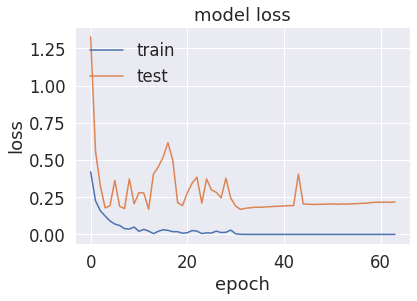

In [26]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Found 1625 files belonging to 4 classes.


2023-01-07 16:14:06.873599: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 978432000 exceeds 10% of free system memory.



              precision    recall  f1-score   support

    COVID-19       0.96      0.98      0.97       407
      Normal       0.97      0.95      0.96       404
   Pneumonia       0.95      0.96      0.96       407
Tuberculosis       0.99      0.98      0.98       407

    accuracy                           0.97      1625
   macro avg       0.97      0.97      0.97      1625
weighted avg       0.97      0.97      0.97      1625



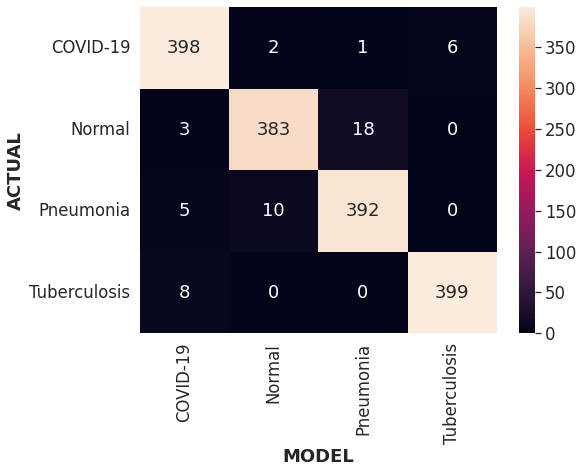

In [25]:
# Multiclass Model Report & Confusion Matrix Heatmap
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report


model = load_model('/kaggle/working/four_class_model_bilstm/')
ds = image_dataset_from_directory('/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/test',
                                    image_size=image_size,
                                    label_mode='categorical',
                                    color_mode='rgb')

target_names = np.array(ds.class_names)
for i, t in enumerate(target_names):
    if t.lower().startswith('corona'):
        target_names[i] = 'COVID-19'
        break
X, Y = [], []
for x, y in ds.unbatch():
    X.append(x)
    Y.append(y)
X, Y = np.array(X), np.array(Y)
Y_true = target_names[Y.argmax(1)]
Y_pred = model.predict(X)
Y_pred = target_names[Y_pred.argmax(1)]
print()
print(classification_report(Y_true, Y_pred))
plt.figure(figsize=(8, 6))
sn.set(font_scale=1.5)
sn.heatmap(
    confusion_matrix(Y_true, Y_pred),
    annot = True, fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('MODEL', fontweight='bold')
plt.ylabel('ACTUAL', fontweight='bold')
plt.show()

In [4]:
#GradCAM Visualization
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, tf.argmax(predictions[0])]
        grads = tape.gradient(loss, convOutputs)
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        print(heatmap.shape, image.shape, 'sdf')
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)


In [ ]:
import cv2
x_model = load_model(r"/kaggle/input/CNN-BiLSTM-four-class-final/four_class_model_bilstm/")
image = cv2.imread(r"/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/train/Normal/101.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (224, 224))
inp = np.expand_dims(image, axis=0)


preds = x_model.predict(inp)
i = np.argmax(preds[0])
ti = ['Corona Virus Disease', 'Normal', 'Pneumonia', 'Tuberculosis'][i]
gcam = GradCAM(x_model, 1, 'max_pooling2d_49')
#gcam = GradCAM(x_model, 1, 'conv2d_69')
#gcam = GradCAM(x_model, 1, 'batch_normalization_49')

heatmap = gcam.compute_heatmap(inp)
(heatmap, output) = gcam.overlay_heatmap(heatmap, image, alpha=0.7, colormap=cv2.COLORMAP_JET)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(ti)
for axi in ax: axi.grid(None)
ax[0].imshow(image)
#ax[1].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
#ax[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
#plt.show()
ax[1].imshow(heatmap)
ax[2].imshow(output)
plt.show()